# **1. Imports**

In [39]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

import PIL
import urllib
import requests

# **2. Data**

In [40]:
# Data
# https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
data_books = pd.read_csv('Books.csv')
data_rating = pd.read_csv('Ratings.csv')
data_users = pd.read_csv('Users.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [41]:
data_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


# **3. Data Cleaning**

In [42]:
# Cross Table
cross_tab = data_books.merge(data_rating, how = 'left', on='ISBN')
cross_tab = cross_tab.merge(data_users, how='left', on='User-ID')

cross_tab.shape

(1032345, 12)

In [43]:
cross_tab.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2.0,0.0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8.0,5.0,"timmins, ontario, canada",NaN
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400.0,0.0,"ottawa, ontario, canada",49.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676.0,8.0,"n/a, n/a, n/a",NaN
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385.0,0.0,"sudbury, ontario, canada",NaN


In [44]:
# Renaming columns
cross_tab.rename(columns={
    'Book-Title': 'title',
    'Book-Author': 'author',
    'Year-Of-Publication': 'year_publication',
    'Publisher': 'publisher',
    'User-ID': 'user',
    'Book-Rating': 'rating',
    'Location': 'location',
    'Age': 'age'
}, inplace=True)

cross_tab.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1032345 entries, 0 to 1032344
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   ISBN              1032345 non-null  object 
 1   title             1032345 non-null  object 
 2   author            1032344 non-null  object 
 3   year_publication  1032345 non-null  object 
 4   publisher         1032343 non-null  object 
 5   Image-URL-S       1032345 non-null  object 
 6   Image-URL-M       1032345 non-null  object 
 7   Image-URL-L       1032341 non-null  object 
 8   user              1031136 non-null  float64
 9   rating            1031136 non-null  float64
 10  location          1031136 non-null  object 
 11  age               753301 non-null   float64
dtypes: float64(3), object(9)
memory usage: 102.4+ MB


In [46]:
# Unique values
cross_tab.nunique()

ISBN                271360
title               242135
author              102023
year_publication       202
publisher            16807
Image-URL-S         271044
Image-URL-M         271044
Image-URL-L         271041
user                 92106
rating                  11
location             22480
age                    141
dtype: int64

In [47]:
# NAs values
cross_tab.isnull().sum()


ISBN                     0
title                    0
author                   1
year_publication         0
publisher                2
Image-URL-S              0
Image-URL-M              0
Image-URL-L              4
user                  1209
rating                1209
location              1209
age                 279044
dtype: int64

In [48]:
# Rating
cross_tab.groupby(by='rating').count()['title']

rating
0.0     647294
1.0       1481
2.0       2375
3.0       5118
4.0       7617
5.0      45355
6.0      31687
7.0      66402
8.0      91804
9.0      60778
10.0     71225
Name: title, dtype: int64

In [49]:
# Remove empty ratings
cross_tab = cross_tab.loc[cross_tab['rating'] > 0]

cross_tab.isnull().sum()

ISBN                     0
title                    0
author                   1
year_publication         0
publisher                2
Image-URL-S              0
Image-URL-M              0
Image-URL-L              1
user                     0
rating                   0
location                 0
age                 114221
dtype: int64

In [50]:
# Analyzing rating by title
titles = cross_tab.groupby(by=['title']).count()[['user']].sort_values('user', ascending=False)
titles

,user
title,
The Lovely Bones: A Novel,707
Wild Animus,581
The Da Vinci Code,494
The Secret Life of Bees,406
The Nanny Diaries: A Novel,393
...,...
Journeys with Elijah: Eight Tales of the Prophet,1
Journeys to Door County,1
"Journeys of Simplicity: Traveling Light With Thomas Merton, Basho, Edward Abbey, Annie Dillard &amp; Others",1


In [51]:
# Filter books with more than 50 ratings
rated_books = titles.loc[titles['user'] > 50]
rated_books.index

Index(['The Lovely Bones: A Novel', 'Wild Animus', 'The Da Vinci Code',
       'The Secret Life of Bees', 'The Nanny Diaries: A Novel',
       'The Red Tent (Bestselling Backlist)', 'Bridget Jones's Diary',
       'A Painted House', 'Life of Pi',
       'Harry Potter and the Chamber of Secrets (Book 2)',
       ...
       'Memoirs of a Geisha', 'Breath, Eyes, Memory', 'Lucky You',
       'Blood Work', 'Diary of a Mad Bride (Summer Display Opportunity)',
       'The Idiot Girls' Action Adventure Club',
       'The Curious Incident of the Dog in the Night-Time (Vintage Contemporaries)',
       'Mr. Maybe', 'Mutant Message Down Under', 'Moonlight Becomes You'],
      dtype='object', name='title', length=626)

In [52]:
# Filter books with more than 50 ratings 
filter_books = cross_tab.loc[cross_tab['title'].isin(rated_books.index)]
filter_books.head()

,ISBN,title,author,year_publication,publisher,Image-URL-S,Image-URL-M,Image-URL-L,user,rating,location,age
31,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,11676.0,9.0,"n/a, n/a, n/a",NaN
32,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,29526.0,9.0,"knoxville, tennessee, usa",26.0
34,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,46398.0,9.0,"san antonio, texas, usa",37.0
36,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,49635.0,9.0,"seattle, washington, usa",NaN
37,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,67958.0,10.0,"idaho falls, idaho, usa",39.0


In [53]:
# Checking if a user rated a book more than once
filter_books.groupby(by=['user', 'title']).count()['author'].sort_values(ascending=False)

user      title                                            
189835.0  The Drawing of the Three (The Dark Tower, Book 2)    4
11676.0   Pet Sematary                                         4
          White Oleander : A Novel                             3
          The Secret Garden                                    3
60244.0   The Phantom Tollbooth                                3
                                                              ..
93453.0   Memoirs of a Geisha                                  1
          One Door Away from Heaven                            1
          Roses Are Red (Alex Cross Novels)                    1
          Shock                                                1
278854.0  Hornet's Nest                                        1
Name: author, Length: 63838, dtype: int64

In [54]:
# Removing duplicates
filter_books.drop_duplicates(['user', 'title'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [55]:
# Generating Rating Matrix
matrix_rating = filter_books.pivot_table(columns='user', index='title', values='rating')

# Removing NA
matrix_rating.fillna(0, inplace=True)

matrix_rating.head(20)

user,9.0,16.0,26.0,32.0,42.0,51.0,91.0,97.0,99.0,114.0,...,278800.0,278807.0,278824.0,278828.0,278832.0,278836.0,278843.0,278844.0,278846.0,278854.0
title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Case of Need,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"A Child Called \It\"": One Child's Courage to Survive""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Confederacy of Dunces (Evergreen Book),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **4. Model**

In [56]:
# Converting values into a sparse matrix with Scipy
rating_matrix_sparse = csr_matrix(matrix_rating)

In [57]:
# Training the model 
model = NearestNeighbors(algorithm='brute')

# Fitting the model
model.fit(rating_matrix_sparse)

NearestNeighbors(algorithm='brute')

In [61]:
# Select a book
selected_book = matrix_rating.index[208]
print(f'Selected book: {selected_book}')

Selected book: Harry Potter and the Chamber of Secrets (Book 2)


In [62]:
# Selecting data in the book dataframe
link = filter_books.loc[filter_books['title']==selected_book].head(1)['Image-URL-L'].values[0]

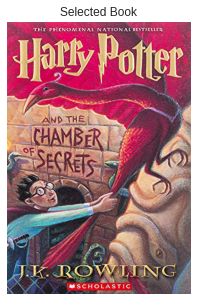

In [63]:
# API to search for the image
image = PIL.Image.open(urllib.request.urlopen(link))

# Plotting the image
plt.figure(figsize=(10,5))
plt.imshow(image)
plt.title('Selected Book')
plt.axis('off');
plt.show()

In [64]:
# Ask for a recommendation
distance, suggestion = model.kneighbors(matrix_rating.iloc[208, :].values.reshape(1, -1))

# Loop to verify the recommendation
for Loop in range(len(suggestion)):
  print(matrix_rating.index[suggestion[Loop]])

Index(['Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Sorcerer's Stone (Book 1)',
       'Don't Stand Too Close to a Naked Man'],
      dtype='object', name='title')


In [65]:
suggestion

array([[208, 211, 209, 212, 144]])

In [66]:
suggestion[0][0]

208

# **5. Final result**

Recommendation of 4 books based on the user first choice. 

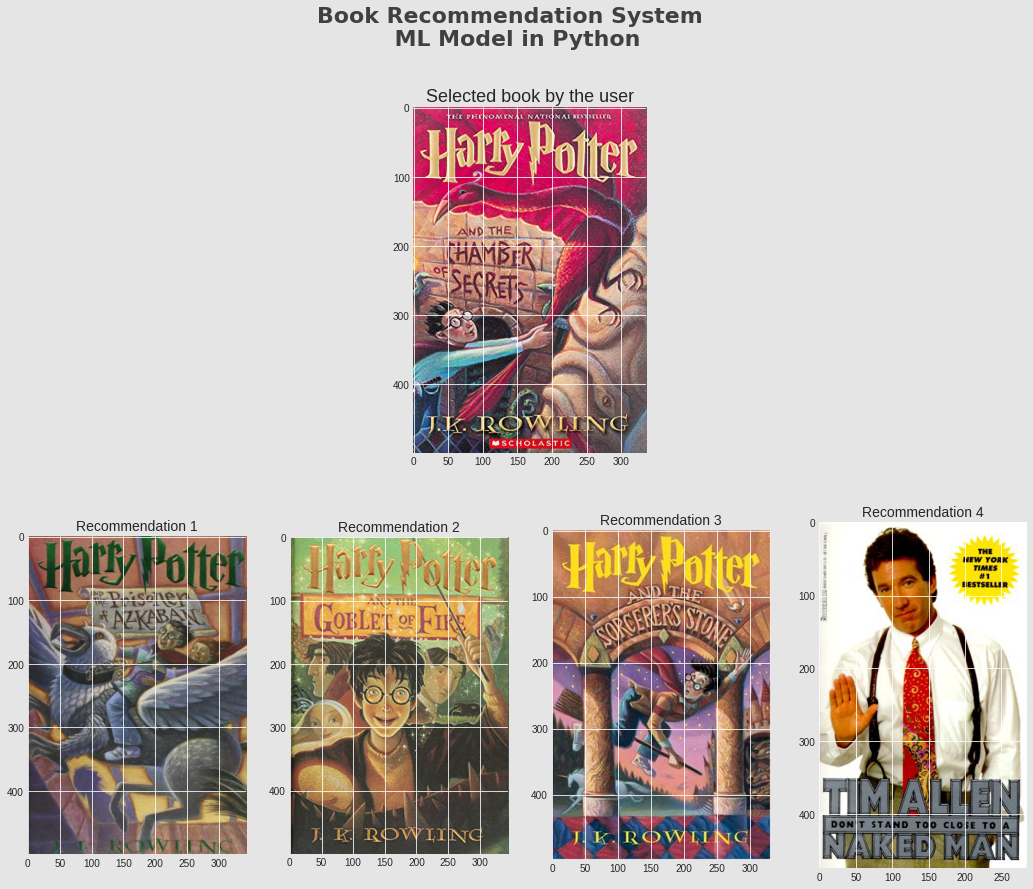

In [71]:
# Figure size 
figure = plt.figure(figsize=(18, 14))

# Set background color
figure.set_facecolor('#e5e5e5')

# Style
plt.style.use('seaborn-darkgrid')

# Including title
plt.suptitle(f'Book Recommendation System \n ML Model in Python', 
             fontsize=22, color='#404040', fontfamily='DejaVu Sans', fontweight=600)

# List to allocate each plot
Axis = [None for _ in range(5)]

# Plot
Axis[0] = plt.subplot2grid((2,4), (0,1), colspan=2)
plt.title('Selected book by the user', loc='center', fontsize=18)
#plt.axis('off')
selected_book = matrix_rating.index[208]
link = filter_books.loc[filter_books['title'] == selected_book].head(1)['Image-URL-L'].values[0]
image = PIL.Image.open(urllib.request.urlopen(link))
plt.imshow(image)

Axis[1] = plt.subplot2grid((2,4), (1,0), colspan=1)
plt.title('Recommendation 1', loc='center', fontsize=14)
#plt.axis('off')
selected_book = matrix_rating.index[suggestion[0][1]]
link = filter_books.loc[filter_books['title'] == selected_book].head(1)['Image-URL-L'].values[0]
image = PIL.Image.open(urllib.request.urlopen(link))
plt.imshow(image)

Axis[2] = plt.subplot2grid((2,4), (1,1), colspan=1)
plt.title('Recommendation 2', loc='center', fontsize=14)
#plt.axis('off')
selected_book = matrix_rating.index[suggestion[0][2]]
link = filter_books.loc[filter_books['title'] == selected_book].head(1)['Image-URL-L'].values[0]
image = PIL.Image.open(urllib.request.urlopen(link))
plt.imshow(image)

Axis[3] = plt.subplot2grid((2,4), (1,2), colspan=1)
plt.title('Recommendation 3', loc='center', fontsize=14)
#plt.axis('off')
selected_book = matrix_rating.index[suggestion[0][3]]
link = filter_books.loc[filter_books['title'] == selected_book].head(1)['Image-URL-L'].values[0]
image = PIL.Image.open(urllib.request.urlopen(link))
plt.imshow(image)

Axis[4] = plt.subplot2grid((2,4), (1,3), colspan=1)
plt.title('Recommendation 4', loc='center', fontsize=14)
#plt.axis('off')
selected_book = matrix_rating.index[suggestion[0][4]]
link = filter_books.loc[filter_books['title'] == selected_book].head(1)['Image-URL-L'].values[0]
image = PIL.Image.open(urllib.request.urlopen(link))
plt.imshow(image)

